# Qibolab v0.1.6 1Q emulator demo for QuTiP engine

Results updated on: 15 May 2024

## Example 0: Emulator Setup

In [1]:
# add directory of emulator platform to QIBOLAB_PLATFORMS environment variable
import pathlib, os
emulator_path = pathlib.Path(os.path.abspath('')).parent/'tests/emulators/'
os.environ["QIBOLAB_PLATFORMS"] = emulator_path.as_posix() 

# create emulator platform as per any other platforms
from qibolab import create_platform
emulator_platform = create_platform("default_q0")
pulse_simulator = emulator_platform.instruments['pulse_simulator']
simulation_engine = pulse_simulator.simulation_engine

[Qibo 0.2.6|INFO|2024-05-17 18:32:41]: Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine
INFO:qibo.config:Loading platform ibmfakebelem_q0 emulator running general no coupler CR drive model on Qutip engine


In [2]:
# import visualization tools
from qibolab_visualization.emulator import print_hamiltonian, plot_fidelities
print_hamiltonian(simulation_engine.model_config)
# todo: add print_sim_details to qibolab_visualization.emulator to include initial state

Dictionary


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



---------------------
One-body drift terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Two-body drift terms:
---------------------
None
---------------------
One-body drive terms:
---------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------
Dissipative terms:
---------------------
>> t1 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

>> t2 Linblad operators:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---------------------


## Example 1: Simulation of Pulse Sequence

### Preparation: Construct Pulse Sequence

In [3]:
from qibolab.pulses import (
    PulseSequence,
    DrivePulse,
    ReadoutPulse,
    Rectangular,
    Gaussian,
    Drag
)

# Extract preset pulses from runcard
pulse_x0 = emulator_platform.create_RX_pulse(qubit=0, start=0)
pulse_r0 = emulator_platform.create_qubit_readout_pulse(qubit=0, start=(170/4.5))

# Define pulse sequence and add pulses
sequence = PulseSequence()
sequence.add(pulse_x0)
sequence.add(pulse_r0)

### Execution: Emulator Pulse and Generate Pulse Sequence

In [4]:
from qibolab.execution_parameters import ExecutionParameters

# Executes a pulse sequence.
options = ExecutionParameters(nshots=1000)#, relaxation_time=100)
results = emulator_platform.execute_pulse_sequence(sequence, options=options)

[Qibo 0.2.6|INFO|2024-05-17 18:32:44]: Minimal execution time (sequence): 0.3050155555555556
INFO:qibo.config:Minimal execution time (sequence): 0.3050155555555556


 Total run time:   1.85s*] Elapsed 1.85s / Remaining 00:00:00:00[*******  32%           ] Elapsed 0.62s / Remaining 00:00:00:01[******** 36%           ] Elapsed 0.76s / Remaining 00:00:00:01


In [6]:
simulation_results = results['simulation']
simulation_results.keys()

dict_keys(['sequence_duration', 'simulation_dt', 'simulation_time', 'output_states'])

In [7]:
simulation_results['simulation_time']

1.8496383329999997

In [13]:
# Generate list of discretized times used in simulation
import numpy as np
sequence_duration = simulation_results['sequence_duration']
simulation_dt = simulation_results['simulation_dt']
sim_time_list = np.linspace(0,sequence_duration,num=int(sequence_duration/simulation_dt)+1)

[0] 0.032064096324280186
[1] 0.9679024705780148
[2] 3.34330976880382e-05


/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_95194/3450508364.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  fidelities = simulation_engine.compute_fidelities(simulated_states)


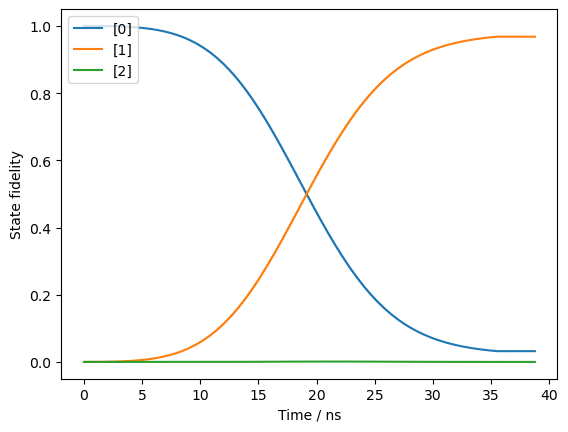

In [14]:
simulated_states = simulation_results['output_states']
fidelities = simulation_engine.compute_fidelities(simulated_states)
plot_fidelities(fidelities,sim_time_list,time_label='Time / ns');

### Print out the Pulse Sequence

In [15]:
from qibolab.instruments.emulator.pulse_simulator import ps_to_waveform_dict, truncate_ro_pulses
pulse_simulator = emulator_platform.instruments['pulse_simulator']
channel_waveforms = ps_to_waveform_dict(
            truncate_ro_pulses(sequence),
            pulse_simulator.platform_to_simulator_channels,
            pulse_simulator.sampling_rate,
            pulse_simulator.sim_sampling_boost,
            pulse_simulator.runcard_duration_in_dt_units,
        )

### Plot the Simulated Waveform

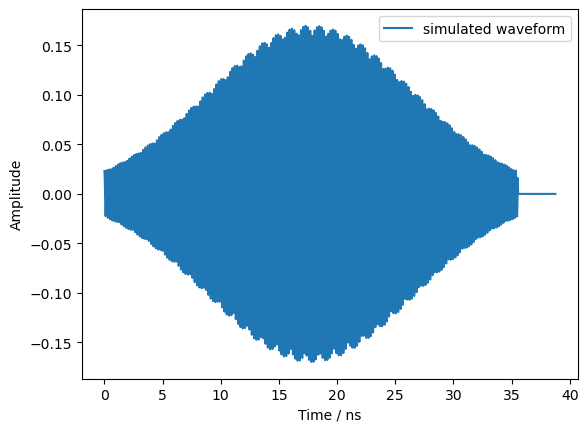

In [16]:
import matplotlib.pyplot as plt
plt.plot(channel_waveforms['time'],channel_waveforms['channels']['D-0'], label='simulated waveform')
plt.xlabel('Time / ns')
plt.ylabel('Amplitude')
plt.legend()

### Perform sampling and apply readout noise

In [50]:
final_state = simulated_states[-1]
final_state.norm()-1

3.774758283725532e-15

In [21]:
from qibolab.instruments.emulator.pulse_simulator import get_samples
ro_qubit_list = [pulse_r0.qubit]
ro_reduced_dm, rdm_qubit_list = pulse_simulator.simulation_engine.qobj_to_reduced_dm(final_state, ro_qubit_list)
samples = get_samples(1000, ro_reduced_dm, rdm_qubit_list, pulse_simulator.simulation_engine.qid_nlevels_map)

samples without noise:

In [52]:
samples[0][:20], np.sum(samples[0])

([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], 964)

Apply `readout_error` to `samples` get `noisy_samples`:

In [53]:
import numpy as np
from qibolab.instruments.emulator.pulse_simulator import apply_readout_noise

readout_error = {0: [0.1, 0.1], 1: [0.1, 0.1]}
noisy_samples = apply_readout_noise(samples, readout_error)
noisy_samples[0][:20], np.sum(noisy_samples[0])

([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0], 873)

## Example 2. Pulse-level Simulation of X0 Gate

### Preparation: 1. Construct qibolab backend with transpiler settings

In [44]:
from qibolab.backends import QibolabBackend
#from qibo.transpiler.pipeline import Passes

# define a compiler rule that translates X to the pi-pulse
def x_rule(gate, platform):
    """X gate applied with a single pi-pulse."""
    qubit = gate.target_qubits[0]
    sequence = PulseSequence()
    sequence.add(platform.create_RX_pulse(qubit, start=0))
    return sequence, {}

emulator_backend = QibolabBackend(platform=emulator_platform)
# disable the transpiler
emulator_backend.transpiler = None
# register the new X rule in the compiler
emulator_backend.compiler[gates.X] = x_rule

In [45]:
zerostate = simulation_engine.psi0.copy()

### Preparation: 2. Prepare test state - X0 gate

In [46]:
from qutip import Qobj
import numpy as np

# prepare test state
qibo_statevector = np.array([0.,1.])
sim_statevector = np.array([0.,1.,0.])
teststate = simulation_engine.make_arbitrary_state(sim_statevector)

# initialize with |00> state
#simulation_engine.psi0 = zerostate
# initialize with test state
simulation_engine.psi0 = teststate

print("qibo test statevector", qibo_statevector)
print(simulation_engine.psi0)

qibo test statevector [0. 1.]
Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[0.]
 [1.]
 [0.]]


### Preparation: 3. Construct the Circuit

In [47]:
from qibo.models import Circuit
from qibo import gates

circ_x0 = Circuit(1)
circ_x0.add(gates.X(0))
circ_x0.add(gates.M(*range(1)))
circ_x0_job = circ_x0(qibo_statevector,nshots=1000)
ideal_x0_results = circ_x0_job.frequencies()

print(circ_x0.draw())
print(ideal_x0_results)
circ_x0_job.state()

q0: ─X─M─
Counter({'0': 1000})


array([1.+0.j, 0.+0.j])

### Execution: Perform Pulse-level Simulation of the X0 Gate

In [48]:
#x0
backend_job = emulator_backend.execute_circuit(circ_x0, nshots=1000)

[Qibo 0.2.6|INFO|2024-05-17 19:43:24]: Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x104ad8070>.
INFO:qibo.config:Connecting to instrument <qibolab.instruments.emulator.pulse_simulator.PulseSimulator object at 0x104ad8070>.
[Qibo 0.2.6|INFO|2024-05-17 19:43:24]: Minimal execution time (sequence): 0.30501333333333336
INFO:qibo.config:Minimal execution time (sequence): 0.30501333333333336


 Total run time:   1.45s*] Elapsed 1.45s / Remaining 00:00:00:00


In [49]:
backend_job.frequencies()

Counter({'0': 963, '1': 37})

## Example 3: Sweeper

In [28]:
from qibolab.sweeper import Sweeper, Parameter

parameter = Parameter.duration
parameter2 = Parameter.amplitude
parameter_range = np.linspace(155/4.5, 165/4.5, num=3)
parameter2_range = np.linspace(0.23045125169257026, 0.25045125169257026, num=3)
sweeper = Sweeper(parameter, parameter_range, [pulse_x0])
sweeper2 = Sweeper(parameter2, parameter2_range, [pulse_x0])

In [29]:
# output only final state
emulator_platform.instruments['pulse_simulator'].output_state_history = False
sweep_results = emulator_platform.sweep(sequence, ExecutionParameters(), sweeper, sweeper2)

[Qibo 0.2.6|INFO|2024-05-17 19:28:16]: Minimal execution time (sweep): 11.24409344
INFO:qibo.config:Minimal execution time (sweep): 11.24409344


sweep param: duration
values [34.44444444 35.55555556 36.66666667]
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.42s*] Elapsed 1.42s / Remaining 00:00:00:00
 [*********57%*          ] Elapsed 0.85s / Remaining 00:00:00:00[*******  31%           ] Elapsed 0.44s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.35s*] Elapsed 1.35s / Remaining 00:00:00:00
sweep param: amplitude
values [0.23045125 0.24045125 0.25045125]
 Total run time:   1.77s*] Elapsed 1.77s / Remaining 00:00:00:00
 [*         4%           ] Elapsed 0.04s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.36s*] Elapsed 1.36s / Remaining 00:00:00:00[*********90%*********  ] Elapsed 1.26s / Remaining 00:00:00:00
 [*********82%*******    ] Elapsed 1.15s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Total run time:   1.50s*] Elapsed 1.50s / Remaining 00:00:00:00
 [*********69%****       ] Elapsed 0.94s / Remaining 00:00:00:00

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [31]:
from qibolab.instruments.emulator.pulse_simulator import make_array_index_list

final_states_array = sweep_results['simulation']['output_states']
shape = final_states_array.shape
index_list = make_array_index_list(shape)
fidelities = {}
for index in index_list:
    pulse_simulator.merge_sweep_results(fidelities, simulation_engine.compute_fidelities(final_states_array[tuple(index)]))

/var/folders/xt/z7_sd24x7mgbzdyf93ck8ph00000gn/T/ipykernel_95194/662018979.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  pulse_simulator.merge_sweep_results(fidelities, simulation_engine.compute_fidelities(final_states_array[tuple(index)]))


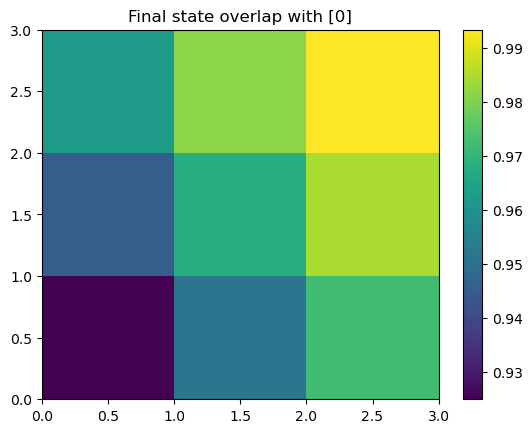

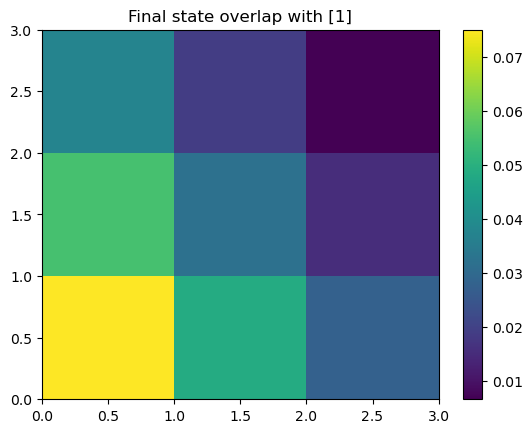

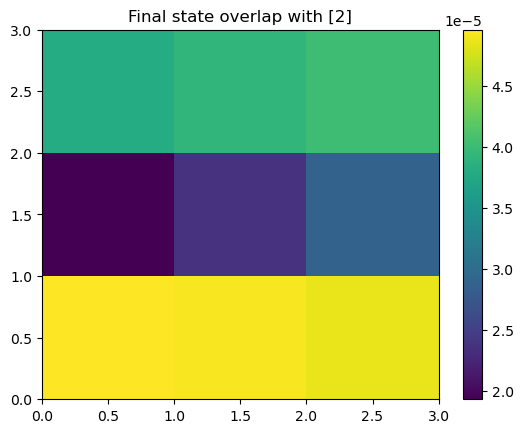

In [32]:
import matplotlib.pyplot as plt
for label in fidelities.keys():
    plt.figure()
    plt.pcolormesh(np.array(fidelities[label]).reshape([3,3]))
    plt.colorbar()
    plt.title(f'Final state overlap with {label}')
    plt.show()

## --- Version information for major packages used in the current Qibolab emulator example ---

In [ ]:
%load_ext watermark

In [ ]:
%watermark -v -p qibolab,qibo,qutip,matplotlib,numpy,scipy